In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

text = "Smiling Girl"
inputs = tokenizer.batch_encode_plus([text])
out = model(input_ids = torch.tensor(inputs['input_ids']),
              attention_mask = torch.tensor(inputs['attention_mask']))

text2 = "Smiling Man"
inputs2 = tokenizer.batch_encode_plus([text2])
out2 = model(input_ids = torch.tensor(inputs2['input_ids']),
              attention_mask = torch.tensor(inputs2['attention_mask']))

text3 = "Man"
inputs3 = tokenizer.batch_encode_plus([text3])
out3 = model(input_ids = torch.tensor(inputs3['input_ids']),
              attention_mask = torch.tensor(inputs3['attention_mask']))

text4= "Girl"
inputs4 = tokenizer.batch_encode_plus([text4])
out4 = model(input_ids = torch.tensor(inputs4['input_ids']),
              attention_mask = torch.tensor(inputs4['attention_mask']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
text = "Man"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [ ]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2366,  0.3746, -0.0201,  ..., -0.1560,  0.0353,  0.3148],
         [-0.3090, -0.1002, -0.2579,  ...,  0.4232,  0.1960,  0.3439],
         [ 0.9614,  0.1757, -0.2739,  ...,  0.1316, -0.8230, -0.1734]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-8.5394e-01, -2.4587e-01,  2.6154e-01,  7.5953e-01, -2.3048e-01,
         -1.3137e-01,  9.1331e-01,  1.7565e-01,  6.3727e-02, -9.9978e-01,
          1.5018e-02,  4.2842e-01,  9.6970e-01, -1.3148e-01,  9.2517e-01,
         -5.4853e-01, -3.5402e-01, -5.2393e-01,  4.2526e-01, -8.1536e-01,
          5.3307e-01,  9.3687e-01,  5.4257e-01,  1.5803e-01,  3.4807e-01,
          5.4057e-01, -6.0427e-01,  9.2051e-01,  9.4436e-01,  6.6388e-01,
         -7.2438e-01,  1.3378e-01, -9.7791e-01, -1.9102e-01,  2.0515e-01,
         -9.7009e-01,  2.2260e-01, -7.1988e-01,  1.0680e-03,  7.8713e-02,
         -8.7189e-01,  1.7718e-01,  9.9694e-01, -1.0316e-01,  5.6670e-03

In [ ]:
encoded_input

{'input_ids': tensor([[ 101, 2158,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [ ]:
model.embeddings.word_embeddings

Embedding(30522, 768, padding_idx=0)

In [ ]:
inputs

{'input_ids': [[101, 5629, 2611, 102]], 'token_type_ids': [[0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1]]}

In [ ]:
out.last_hidden_state[:,0].shape

torch.Size([1, 768])

In [ ]:
import torch

# 예제 텐서
a = torch.tensor(out.last_hidden_state[:,0,:].clone().detach().requires_grad_(True))
b = torch.tensor(out2.last_hidden_state[:,0,:].clone().detach().requires_grad_(True))
c = torch.tensor(out3.last_hidden_state[:,0,:].detach().requires_grad_(True))
d = torch.tensor(out4.last_hidden_state[:,0,:].detach().requires_grad_(True))

# # 방법 1: 직접 계산
distance = torch.sqrt(torch.sum((a-c) ** 2))
distance

<ipython-input-9-2141e097bed1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(out.last_hidden_state[:,0,:].clone().detach().requires_grad_(True))
<ipython-input-9-2141e097bed1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(out2.last_hidden_state[:,0,:].clone().detach().requires_grad_(True))
<ipython-input-9-2141e097bed1>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(out3.last_hidden_state[:,0,:].detach().requires_grad_(True))
<ipython-input-9-2141e097bed1>:7: UserWarning: To copy 

tensor(5.1955)

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
all_files = glob.glob('/content/drive/MyDrive/deeplearning/processed_rating'+ "/*.csv")

# 각 파일을 DataFrame으로 읽어서 리스트에 저장
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

# DataFrame 합치기
merged_df = pd.concat(li, axis=0, ignore_index=True)

# 결과 확인


   Unnamed: 0                                      Category  \
0           0  A movie in the genre of Action and Adventure   
1           1  A movie in the genre of Action and Adventure   
2           2  A movie in the genre of Action and Adventure   
3           3  A movie in the genre of Action and Adventure   
4           4  A movie in the genre of Action and Adventure   

                                              Review  Rating title  
0  This is by far the best Spider-Man or even Mar...    10.0   NaN  
1  Coming from someone who doesn’t like the previ...    10.0   NaN  
2  Marvel has outdone themselves. This is the qui...    10.0   NaN  
3  Saw this #FDFS at 5am\nYou beauty Spider-Man\n...    10.0   NaN  
4  Best in the Spiderman line, and it takes top s...    10.0   NaN  


In [ ]:
merged_df=merged_df.reset_index()[['Category','Review','Rating']]
merged_df

,Category,Review,Rating
0,A movie in the genre of Action and Adventure,This is by far the best Spider-Man or even Mar...,10.0
1,A movie in the genre of Action and Adventure,Coming from someone who doesn’t like the previ...,10.0
2,A movie in the genre of Action and Adventure,Marvel has outdone themselves. This is the qui...,10.0
3,A movie in the genre of Action and Adventure,Saw this #FDFS at 5am\nYou beauty Spider-Man\n...,10.0
4,A movie in the genre of Action and Adventure,"Best in the Spiderman line, and it takes top s...",10.0
...,...,...,...
10666646,Restaurant,Prices was s little to high out there,6.0
10666647,Restaurant,Buen servicio muy ricas alas. Todo excelente y...,10.0
10666648,Restaurant,The best friend rice I've ever had.,10.0
10666649,Restaurant,"The menu advertises a different price, and the...",6.0


In [ ]:
merged_df['Rating'].value_counts()

,count
Rating,
10.0,5208172
8.0,2416044
6.0,1376029
4.0,834793
2.0,802544
9.0,17789
7.0,7046
5.0,2209
3.0,640


In [ ]:
# Step 1: Rating == 10.0인 데이터 분리
df_10 = merged_df[merged_df['Rating'] == 10.0]
df_8 = merged_df[merged_df['Rating'] == 8.0]
df_6 = merged_df[merged_df['Rating'] == 6.0]
df_rest = merged_df[~merged_df['Rating'].isin([10.0, 8.0, 6.0])]

# Step 2: Category별로 균형 잡힌 샘플링을 위해 비율 계산
category_counts10 = df_10['Category'].value_counts()
category_counts8 = df_8['Category'].value_counts()
category_counts6 = df_6['Category'].value_counts()
total_10 = len(df_10)
total_8 = len(df_8)
total_6 = len(df_6)

# Step 3: 전체에서 80000개만 남기기 위한 비율 기반 샘플링 수 계산
target_total = 840000
category_sample_counts10 = (category_counts10 / total_10 * target_total).round().astype(int)
category_sample_counts8 = (category_counts8 / total_8 * target_total).round().astype(int)
category_sample_counts6 = (category_counts6 / total_6 * target_total).round().astype(int)

# Step 4: 각 Category에서 샘플링
sampled_10 = pd.concat([
    df_10[df_10['Category'] == category].sample(n=min(count, len(df_10[df_10['Category'] == category])), random_state=42)
    for category, count in category_sample_counts10.items()
])
sampled_8 = pd.concat([
    df_8[df_8['Category'] == category].sample(n=min(count, len(df_8[df_8['Category'] == category])), random_state=42)
    for category, count in category_sample_counts8.items()
])
sampled_6 = pd.concat([
    df_6[df_6['Category'] == category].sample(n=min(count, len(df_6[df_6['Category'] == category])), random_state=42)
    for category, count in category_sample_counts6.items()
])

# Step 5: 최종 데이터프레임 만들기
final_df = pd.concat([df_rest, sampled_10,sampled_8,sampled_6])

# 결과 확인
print("최종 데이터 크기:", final_df.shape)
print("Rating 분포:\n", final_df['Rating'].value_counts())
print("10.0의 Category 다양성:", sampled_10['Category'].nunique())
print("8.0의 Category 다양성:", sampled_8['Category'].nunique())
print("6.0의 Category 다양성:", sampled_6['Category'].nunique())

최종 데이터 크기: (4186394, 3)
Rating 분포:
 Rating
10.0    840000
8.0     839994
6.0     839994
4.0     834793
2.0     802544
9.0      17789
7.0       7046
5.0       2209
3.0        640
1.0        397
9.6        328
9.2        198
8.8        170
8.4        112
7.6         56
7.2         40
6.8         26
6.4         20
5.6         12
4.4          8
5.2          8
4.8          4
3.2          2
3.6          2
2.8          2
Name: count, dtype: int64
10.0의 Category 다양성: 303
8.0의 Category 다양성: 266
6.0의 Category 다양성: 240


In [ ]:
final_df.to_csv('/content/drive/MyDrive/deeplearning/processed_rating/final.csv')

In [ ]:
final_df=pd.read_csv('/content/drive/MyDrive/deeplearning/processed_rating/final.csv')

In [ ]:
print("Rating 분포:\n", final_df['Rating'].value_counts())

Rating 분포:
 Rating
10.0    840000
8.0     839994
6.0     839994
4.0     834793
2.0     802544
9.0      17789
7.0       7046
5.0       2209
3.0        640
1.0        397
9.6        328
9.2        198
8.8        170
8.4        112
7.6         56
7.2         40
6.8         26
6.4         20
5.6         12
4.4          8
5.2          8
4.8          4
3.2          2
3.6          2
2.8          2
Name: count, dtype: int64


In [ ]:
print("Category 다양성:", final_df['Category'].nunique())
df_10 = final_df[final_df['Rating'] == 10.0]
df_8 = final_df[final_df['Rating'] == 8.0]
df_6 = final_df[final_df['Rating'] == 6.0]
df_4 = final_df[final_df['Rating'] == 4.0]
df_2 = final_df[final_df['Rating'] == 2.0]
print("score 2 Category 다양성:", df_2['Category'].nunique())
print("score 4 Category 다양성:", df_4['Category'].nunique())
print("score 6 Category 다양성:", df_6['Category'].nunique())
print("score 8 Category 다양성:", df_8['Category'].nunique())
print("score 10 Category 다양성:", df_10['Category'].nunique())

Category 다양성: 312
score 2 Category 다양성: 237
score 4 Category 다양성: 223
score 6 Category 다양성: 240
score 8 Category 다양성: 266
score 10 Category 다양성: 303


In [ ]:
final_df.value_counts('Category')

,count
Category,
A book in the genre of 'Comics & Graphic Novels',2006020
Multivitamin Pack,59224
Hydrating Facial Serum,59179
Self-Help Motivational Book,59151
Water Bottle,59113
...,...
Screwdrivers,1
Pullers & Extractors,1
A product in the category of Baby Products,1


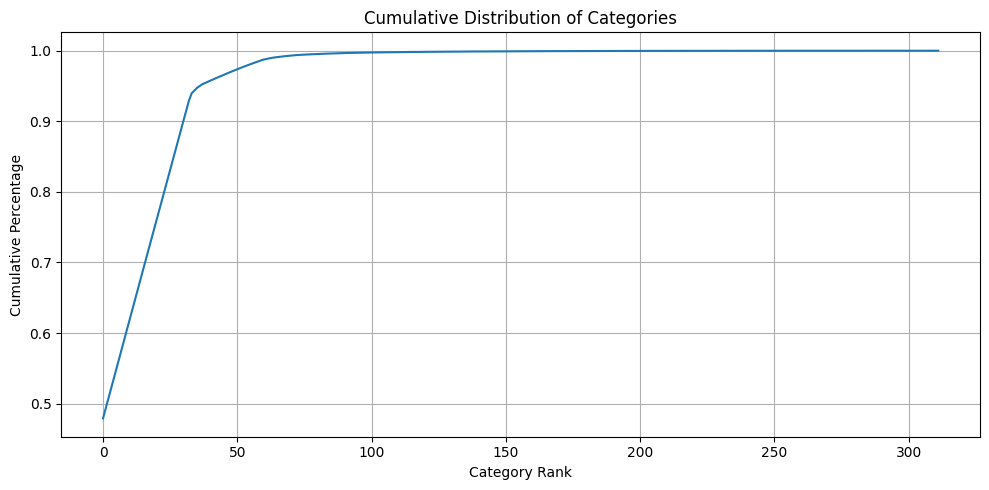

In [ ]:
import numpy as np

# 누적 비율 계산
cum_sum = category_counts.cumsum()
cum_perc = cum_sum / category_counts.sum()

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(cum_perc)), cum_perc.values)
plt.xlabel('Category Rank')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Categories')
plt.grid(True)
plt.tight_layout()
plt.show()

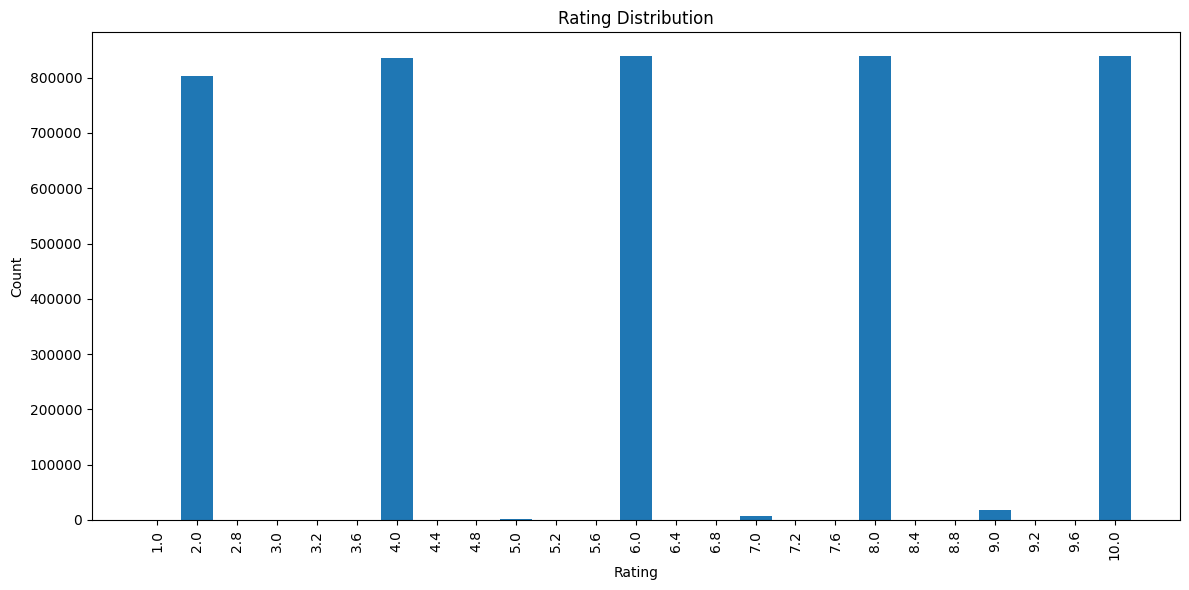

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 생성
rating_data = {
    10.0: 840000,
    8.0: 839994,
    6.0: 839994,
    4.0: 834793,
    2.0: 802544,
    9.0: 17789,
    7.0: 7046,
    5.0: 2209,
    3.0: 640,
    1.0: 397,
    9.6: 328,
    9.2: 198,
    8.8: 170,
    8.4: 112,
    7.6: 56,
    7.2: 40,
    6.8: 26,
    6.4: 20,
    5.6: 12,
    4.4: 8,
    5.2: 8,
    4.8: 4,
    3.2: 2,
    3.6: 2,
    2.8: 2
}

# DataFrame으로 변환 후 정렬
df = pd.Series(rating_data).sort_index()

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(df.index.astype(str), df.values)
plt.xticks(rotation=90)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# 예시 DataFrame
# df = pd.DataFrame({'feature1': ..., 'feature2': ..., 'label': ...})
final_df.reset_index(drop=True,inplace=True)
X = final_df[['Category', 'Review']]  # 2개의 feature
y = final_df['Rating']                   # 1개의 라벨

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

In [ ]:
y

,Rating
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
4186389,6.0
4186390,6.0
4186391,6.0
4186392,6.0


In [ ]:
import torch.nn as nn
from transformers import BertModel

class RatingRegression(nn.Module):
    def __init__(self, feature_dim, dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        # 768(BERT CLS) + feature_dim(추가 feature 차원)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.regressor = nn.Sequential(
            nn.Linear(768+feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )


    def forward(self, input_ids, attention_mask, features1, features2):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_out2 = self.bert(input_ids=features1, attention_mask=features2)

        cls_emb = bert_out.last_hidden_state[:, 0, :]
        cls_emb2 = bert_out2.last_hidden_state[:, 0, :]

        cos_sim = nn.CosineSimilarity(dim=1)(cls_emb, cls_emb2)  # (B,)
        cos_sim = cos_sim.unsqueeze(1)  # (B, 1)
        cos_sim = cos_sim * 5
        cos_sim = cos_sim.expand(-1, 32)  # (B, 32)

        concat = torch.cat([cos_sim, cls_emb], dim=1)  # 최종 concat: (B, 800)
        score = self.regressor(concat)
        return score

In [ ]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, feature, label, tokenizer):
#         self.df=final_df
#         self.texts = feature['Review']
#         self.features = feature['Category']
#         self.labels = label
#         self.tokenizer = tokenizer

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         # encoding = self.tokenizer(
#         #     self.texts[idx],
#         #     padding='max_length',
#         #     truncation=True,
#         #     max_length=self.max_len,
#         #     return_tensors='pt'
#         # )
#         reviewvec = self.tokenizer.batch_encode_plus(self.texts[idx])
#         categoryvec = self.tokenizer.batch_encode_plus(self.features[idx])
#         label = torch.tensor(self.labels[idx], dtype=torch.float)
#         return {
#             'input_ids': reviewvec['input_ids'],
#             'attention_mask': reviewvec['attention_mask'],
#             'features1': categoryvec['input_ids'],
#             'features2' : categoryvec['attention_mask'],
#             'labels': label
#         }

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, feature, label, tokenizer):
        # ✅ 정확한 데이터 저장
        self.texts = feature['Review'].astype(str).reset_index(drop=True)
        self.features = feature['Category'].astype(str).reset_index(drop=True)
        self.labels = label.reset_index(drop=True)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)  # ✅ 또는 len(self.texts)

    def __getitem__(self, idx):
        # ✅ tokenizer는 return_tensors='pt' 필수
        reviewvec = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        categoryvec = self.tokenizer(
            self.features[idx],
            padding='max_length',
            truncation=True,
            max_length=32,
            return_tensors='pt'
        )

        label = torch.tensor(self.labels[idx], dtype=torch.float)

        return {
            'input_ids': reviewvec['input_ids'].squeeze(0),
            'attention_mask': reviewvec['attention_mask'].squeeze(0),
            'features1': categoryvec['input_ids'].squeeze(0),
            'features2': categoryvec['attention_mask'].squeeze(0),
            'labels': label
        }

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time

rr = RatingRegression(32)
optimizer = torch.optim.Adam(params=rr.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = CustomDataset(X_train, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rr = rr.to(device)
rr.train()

train_loss_avg = []

print('Training ...')
for epoch in range(1):
    num_batches = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features1 = batch['features1'].to(device)
        features2 = batch['features2'].to(device)
        labels = batch['labels'].to(device)

        outputs = rr(input_ids=input_ids, attention_mask=attention_mask, features1=features1, features2=features2)
        loss = criterion(outputs.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Training ...


100%|██████████| 104660/104660 [3:00:34<00:00,  9.66it/s]


In [ ]:
loss

tensor(1.8129, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
torch.save(rr.state_dict(),'/content/drive/MyDrive/deeplearning/models/rr1.pth')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rr = rr.to(device)
rr.eval()

text2 = "A boy"
text3 = "it is like a handsome guy"
inputs2 = tokenizer.batch_encode_plus([text2], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
inputs3 = tokenizer.batch_encode_plus([text3], padding='max_length', truncation=True, max_length=32, return_tensors='pt')

out3 = rr(
    input_ids = inputs2['input_ids'].to(device),
    attention_mask = inputs2['attention_mask'].to(device),
    features1 = inputs3['input_ids'].to(device),
    features2 = inputs3['attention_mask'].to(device)
)

In [ ]:
out3

tensor([[7.0297]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
import torch.nn as nn
from transformers import BertModel

class RatingRegression2(nn.Module):
    def __init__(self, feature_dim, dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.regressor = nn.Sequential(
            nn.Linear(768+feature_dim, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )


    def forward(self, input_ids, attention_mask, features1, features2):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_out2 = self.bert(input_ids=features1, attention_mask=features2)

        cls_emb = bert_out.last_hidden_state[:, 0, :]
        cls_emb2 = bert_out2.last_hidden_state[:, 0, :]

        concat = torch.cat([cls_emb, cls_emb2], dim=1)  # 최종 concat: (B, 800)
        score = self.regressor(concat)
        return score

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time

rr2 = RatingRegression2(768)
optimizer2 = torch.optim.Adam(params=rr2.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset2 = CustomDataset(X_train, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rr2 = rr2.to(device)
rr2.train()

train_loss_avg = []

print('Training ...')
for epoch in range(1):
    train_loss_avg.append(0)
    num_batches = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features1 = batch['features1'].to(device)
        features2 = batch['features2'].to(device)
        labels = batch['labels'].to(device)

        outputs2 = rr2(input_ids=input_ids, attention_mask=attention_mask, features1=features1, features2=features2)
        loss2 = criterion(outputs2.squeeze(), labels)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()


torch.save(rr2.state_dict(),'/content/drive/MyDrive/deeplearning/models/rr2.pth')

ValueError: dropout probability has to be between 0 and 1, but got 768

In [ ]:
import torch.nn as nn
from transformers import BertModel

class RatingRegression3(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.encoder1 = nn.Sequential(
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.Tanh()
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(768, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.Tanh()
        )
        self.regressor = nn.Sequential(
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
        )


    def forward(self, input_ids, attention_mask, features1, features2):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_out2 = self.bert(input_ids=features1, attention_mask=features2)

        cls_emb = bert_out.last_hidden_state[:, 0, :]
        cls_emb2 = bert_out2.last_hidden_state[:, 0, :]

        cls_emb = self.encoder1(cls_emb)
        cls_emb2 = self.encoder2(cls_emb2)
        cos_sim = nn.CosineSimilarity(dim=1)(cls_emb, cls_emb2)
        cos_sim = cos_sim.unsqueeze(1)
        cos_sim = cos_sim.expand(-1, 32)

        concat = torch.cat([cos_sim, cls_emb], dim=1)  # 최종 concat: (B, 800)
        score = self.regressor(concat)
        return score

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time

rr3 = RatingRegression3()
optimizer3 = torch.optim.Adam(params=rr3.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset3 = CustomDataset(X_train, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset3, batch_size=32, shuffle=True)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rr3 = rr3.to(device)
rr3.train()

train_loss_avg = []

print('Training ...')
for epoch in range(1):
    num_batches = 0

    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features1 = batch['features1'].to(device)
        features2 = batch['features2'].to(device)
        labels = batch['labels'].to(device)

        outputs3 = rr3(input_ids=input_ids, attention_mask=attention_mask, features1=features1, features2=features2)
        loss3 = criterion(outputs3.squeeze(), labels)
        optimizer3.zero_grad()
        loss3.backward()
        optimizer3.step()


torch.save(rr3.state_dict(),'/content/drive/MyDrive/deeplearning/models/rr3.pth')

Training ...


100%|██████████| 104660/104660 [3:06:45<00:00,  9.34it/s]


In [ ]:
import torch
rr1 = RatingRegression(32)
rr1.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/rr1.pth',map_location=torch.device('cpu')))
rr1.eval()
rr2 = RatingRegression2(768)
rr2.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/rr2.pth',map_location=torch.device('cpu')))
rr2.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

RatingRegression2(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
rr3 = RatingRegression3()
rr3.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/rr3.pth',map_location=torch.device('cpu')))
rr3.eval()

RatingRegression3(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
test_dataset = CustomDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds = []
all_targets = []
rr1=rr1.to(device)
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features1 = batch['features1'].to(device)
        features2 = batch['features2'].to(device)
        labels = batch['labels'].to(device)

        outputs = rr1(input_ids=input_ids, attention_mask=attention_mask, features1=features1, features2=features2)
        all_preds.append(outputs.cpu())
        all_targets.append(labels.cpu())

preds = torch.cat(all_preds).numpy()
targets = torch.cat(all_targets).numpy()

100%|██████████| 26165/26165 [45:47<00:00,  9.52it/s]


In [ ]:
test_dataset = CustomDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds2 = []
all_targets2 = []
rr2=rr2.to(device)
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features1 = batch['features1'].to(device)
        features2 = batch['features2'].to(device)
        labels = batch['labels'].to(device)

        outputs = rr2(input_ids=input_ids, attention_mask=attention_mask, features1=features1, features2=features2)
        all_preds2.append(outputs.cpu())
        all_targets2.append(labels.cpu())

preds2 = torch.cat(all_preds2).numpy()
targets2 = torch.cat(all_targets2).numpy()

100%|██████████| 26165/26165 [45:45<00:00,  9.53it/s]


In [ ]:
test_dataset = CustomDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
all_preds3 = []
all_targets3 = []
rr3=rr3.to(device)
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features1 = batch['features1'].to(device)
        features2 = batch['features2'].to(device)
        labels = batch['labels'].to(device)

        outputs = rr3(input_ids=input_ids, attention_mask=attention_mask, features1=features1, features2=features2)
        all_preds3.append(outputs.cpu())
        all_targets3.append(labels.cpu())

preds3 = torch.cat(all_preds3).numpy()
targets3 = torch.cat(all_targets3).numpy()

100%|██████████| 26165/26165 [46:12<00:00,  9.44it/s]


In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/deeplearning/models/preds1', preds)
np.save('/content/drive/MyDrive/deeplearning/models/preds2', preds2)
np.save('/content/drive/MyDrive/deeplearning/models/preds3', preds3)
np.save('/content/drive/MyDrive/deeplearning/models/targets1', targets)
np.save('/content/drive/MyDrive/deeplearning/models/targets2', targets2)
np.save('/content/drive/MyDrive/deeplearning/models/targets3', targets3)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error



# preds, targets는 위에서 수집한 예측값과 실제값 numpy 배열
mae = mean_absolute_error(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
r2 = r2_score(targets, preds)
mape = mean_absolute_percentage_error(targets, preds) * 100

print(f"M1_MAE: {mae:.4f}")
print(f"M1_MSE: {mse:.4f}")
print(f"M1_RMSE: {rmse:.4f}")
print(f"M1_R^2: {r2:.4f}")
print(f"M1_MAPE: {mape:.4f}")

mae = mean_absolute_error(targets2, preds2)
mse = mean_squared_error(targets2, preds2)
rmse = np.sqrt(mse)
r2 = r2_score(targets2, preds2)
mape = mean_absolute_percentage_error(targets2, preds2) * 100

print(f"M2_MAE: {mae:.4f}")
print(f"M2_MSE: {mse:.4f}")
print(f"M2_RMSE: {rmse:.4f}")
print(f"M2_R^2: {r2:.4f}")
print(f"M2_MAPE: {mape:.4f}")

mae = mean_absolute_error(targets3, preds3)
mse = mean_squared_error(targets3, preds3)
rmse = np.sqrt(mse)
r2 = r2_score(targets3, preds3)
mape = mean_absolute_percentage_error(targets3, preds3) * 100

print(f"M3_MAE: {mae:.4f}")
print(f"M3_MSE: {mse:.4f}")
print(f"M3_RMSE: {rmse:.4f}")
print(f"M3_R^2: {r2:.4f}")
print(f"M3_MAPE: {mape:.4f}")

M1_MAE: 1.2772
M1_MSE: 2.9416
M1_RMSE: 1.7151
M1_R^2: 0.6287
M1_MAPE: 31.3065
M2_MAE: 1.2552
M2_MSE: 2.9345
M2_RMSE: 1.7130
M2_R^2: 0.6295
M2_MAPE: 30.1162
M3_MAE: 1.3386
M3_MSE: 3.2044
M3_RMSE: 1.7901
M3_R^2: 0.5955
M3_MAPE: 32.4278


In [ ]:
from transformers import BertTokenizer, BertModel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
rr1 = rr1.to(device)
rr1.eval()

rev = "It's very hot and steaming"
cat = "a ice pack"
revvec = tokenizer.batch_encode_plus([rev], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
catvec = tokenizer.batch_encode_plus([cat], padding='max_length', truncation=True, max_length=32, return_tensors='pt')

print(rr1(
    input_ids = revvec['input_ids'].to(device),
    attention_mask = revvec['attention_mask'].to(device),
    features1 = catvec['input_ids'].to(device),
    features2 = catvec['attention_mask'].to(device)
))

tensor([[6.7892]], grad_fn=<AddmmBackward0>)


In [ ]:
print("model1 : ", sum(p.numel() for p in rr1.parameters() if p.requires_grad))
print("model2 : ", sum(p.numel() for p in rr2.parameters() if p.requires_grad))
print("model3 : ", sum(p.numel() for p in rr3.parameters() if p.requires_grad))

model1 :  222081
model2 :  1395329
model3 :  435969
